# Table Extraction Case Study
### AAIC Self Case Study II
### Author: Soumya De

<hr>

## 7. Final Pipeline Method

We will now make use of the compressed tflite model that we have obtained in the previous section and design our final pipeline, that is from getting an image (as a file on the disk) to obtain a csv (also as file on the disk) 

In [5]:
# importing dependencies
import os
import re
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from time import strftime
import pytesseract
import tensorflow as tf
from tensorflow.keras import Model

In [2]:
# defining helper functions 
def load_interpreter(model_path=None):
    """
    This function loads a tflite model interpreter 
    """
    if model_path is None:
        model_path = os.path.sep.join(['final_model', 'tablenet_densenet121_lite.tflite'])
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter 

def adjust(new_rows, maxi):
    """
    A function to set all with maxi number of columns
    for making csv compatible
    """
    rows = []
    for each_row in new_rows:
        if len(each_row) < maxi:
            for i in range(maxi - len(each_row)):
                each_row.append("-")
        rows.append(each_row)
    return rows

def text2csv(text):
    """
    This funtion transorms a text with newline and spaces to
    a csv that treats the spaces in the text as comma and newlines as carriage return
    """
    rows = text.split('\n')
    new_rows = []
    maxi = 0
    for each_row in rows:
        temp_row = each_row.split()
        if maxi < len(temp_row):
            maxi = len(temp_row)
        new_rows.append(temp_row)
    new_rows = adjust(new_rows, maxi)
    header = ['column_{}'.format(i) for i in range(maxi)]
    tstr = strftime("%Y%m%d-%H%M")
    temp_dir = os.path.join('output', 'temporary_files')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    temp_file = os.path.join(temp_dir, 'temp_{}.csv'.format(tstr))

    with open(temp_file, 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(header)
        csvwriter.writerows(new_rows)
    return temp_file

def append_offset(name, offset):
    """
    This function is used for assigning a name with offset if a file with the same name exists
    It takes a filename and a offset and returns a valid equivalent name with offset number
    
    Example :
    # assume two variables 
    name = 'python.py'
    offset = '2'
    append_offset(name, offset)
    
    # The above invocation will return string as
    # 'python_2.py'
    """
    fname, extension = name.split('.')
    fname = ''.join([fname, '_', offset, '.', extension])
    return fname

def render(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

def visualize(image):
    plt.figure(figsize=(15, 15))
    title = 'Cropped Table'
    plt.title(title)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')
    plt.show()


In [21]:
def final(img_path, output_dir='temp_output', show_table=False):
    
    interpreter = load_interpreter()
    image_orig = Image.open(img_path)
    original_dim = image_orig.size
    image = image_orig.resize((512,512))
    np_image = np.asarray(image)/255.0
    np_image = np_image.astype(np.float32)
    np_image = np.expand_dims(np_image, axis=0)

    ip_d = interpreter.get_input_details()[0]
    op_d = interpreter.get_output_details()[0]

    interpreter.set_tensor(ip_d['index'], np_image)
    interpreter.invoke()
    
    tab_mask = interpreter.get_tensor(op_d['index'])

    
    tab_mask = np.squeeze(render(tab_mask).numpy())

    tab_mask = Image.fromarray(np.uint8(tab_mask))
    tab_mask = tab_mask.resize(original_dim)

    tab_mask = np.array(tab_mask)

    image_orig = image_orig
    x, y, w, h = cv2.boundingRect(tab_mask)
    tab = image_orig.crop((x, y, x+w, y+h))
    

    text = pytesseract.image_to_string(tab)
    text = text.strip()
    text = re.sub("[\r\n]+", "\r\n", text)
    csv = text2csv(text)
    csv_fname = img_path.split(os.path.sep)[-1].replace('png', 'csv')
    dest_dir = os.path.join(output_dir)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    dest = os.path.join(dest_dir, csv_fname)
    # if file already exists in the temp directory it will save the csv 
    # by appending some offset to the filename before extension
    try:
        os.rename(csv, dest)
    except:
        f_save = 'fail'
        i=2
        while(f_save=='fail'):
            name_off = str(i)
            try:
                dest = os.path.join(dest_dir, append_offset(csv_fname,name_off))
                os.rename(csv, dest)
                f_save = 'pass'
            except:
                i += 1

    if show_table:
        visualize(tab)

    return dest

### Inference using the final function

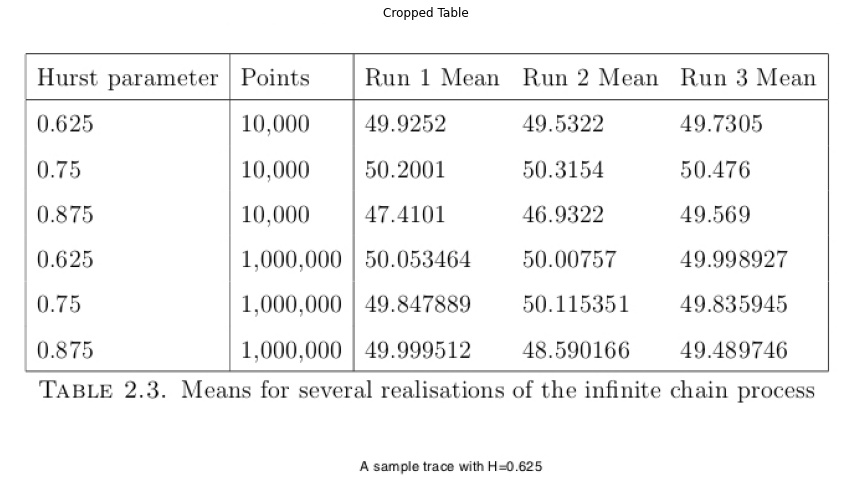

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
0,Hurst,parameter,|,Points,Run,1,Mean,Run,2,Mean,Run,3,Mean
1,0.625,"10,000",49.9252,49.5322,49.7305,-,-,-,-,-,-,-,-
2,0.75,"10,000.",50.2001,50.3154,50.476,-,-,-,-,-,-,-,-
3,0.875,"10,000",47.4101,46.9322,49.569,-,-,-,-,-,-,-,-
4,0.625,"1,000,000",|,50.053464,50.00757,49.998927,-,-,-,-,-,-,-
5,0.75,"1,000,000",|,49.847889,50.115351,49.835945,-,-,-,-,-,-,-
6,0.875,"1,000,000",|,49.999512,48.590166,49.489746,-,-,-,-,-,-,-
7,-,-,-,-,-,-,-,-,-,-,-,-,-
8,TABLE,2.3.,Means,for,several,realisations,of,the,infinite,chain,process,-,-
9,�(A,sample,trace,with,H=0.625,-,-,-,-,-,-,-,-


In [22]:
img_path = os.path.join('data', 'ICDAR 2017', 'table_images', 'POD_0011.png')
csv_path = final(img_path, show_table=True)
df = pd.read_csv(csv_path)
df